### ACF and PACF

- ACF - Auto Correlation Function
- PACF - Parcial Auto Correlation Function

### Auto Correlation

Looks at the correlation of the data and compares it with itself at different lag periods

it is common to see either a gradual decline or a steep drop off with the values.

We use this to link in with the ARIMA model to decide on our orders.

### Partial Auto Correlation Plots

We start in the same way as the Auto Correlation except we plot out the residuals, we then fit the residuals against the sales of day t-(x+1) and this carries on for all of the steps.

This is used as a relationship for the time series and we generally see a sharp drop off and we are looking for how long until we see this drop off into white noise.

Let's now create these plots with stats models.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

df1 = pd.read_csv('data\\Time Series\\airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq='MS'

df2 = pd.read_csv('data\\Time Series\\DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq='D'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.DataFrame({'a':[13,5,11,12,9]})

acf(df['a'])

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

There are multiple methods to calculate the Partial Auto Correlation function:

In [4]:
pacf_yw(df['a'],nlags=4,method='mle')

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

But we should rather focus on the ability to plot these out:

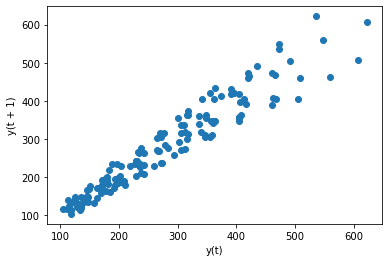

In [5]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers'])

we can see that there is some correlations based on the direction of the graph, but what happens when we plot the stationary dataset out (below):

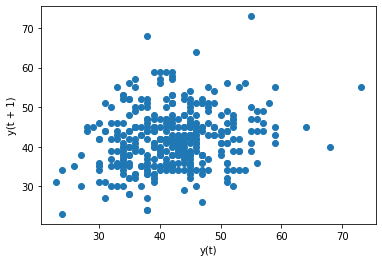

In [6]:
lag_plot(df2['Births'])

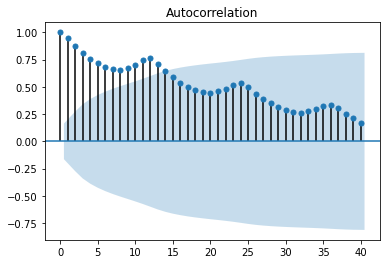

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df1['Thousands of Passengers'],lags=40);

We now have a clear plot of the auto correlations and we can also see the peaks from the seasonality in the data.
The shaded region is the 95% confidence interval. So all values outside of this is highly likely to be significant and actual correlations.

If we look at the stationary data we can see that there is a big drop off in the Auto Correlation from lag 0:

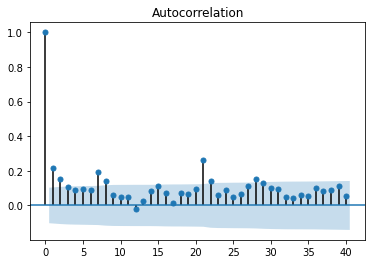

In [8]:
plot_acf(df2['Births'],lags=40);

Let's have a look at the PACF plot - in general these work better with stationary data so we will start with the births data first:

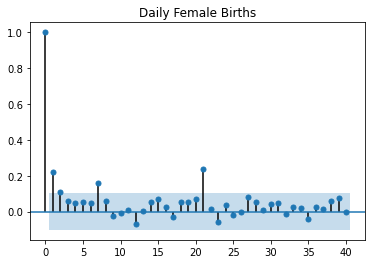

In [9]:
plot_pacf(df2['Births'],lags=40,title='Daily Female Births');

If there is a sharp cut off in PACF it is an indication of an AR term that needs to be added to the model.

### Armima Overview

This is one of the most common time Series models which most of the models are based off.

There is three components
AR - Auto Regressive
I - Intergrated
MA - Moving Average

They are powerful tools but can't always predict things when there are outside factors that should also be considered.

This model is a generalization of the ARMA model and is fitted to time series data to understand it and predict future points in the forecast.

Arima can be applied when there is non Stationairty by including a differencing prior to the ARIMA fitting.

Non-Seasonal ARIMA models are ARIMA(p,d,q)
All are non negative intergers

- p - AR component
    - A regression model that utilized the dependent relationship between the current and the observations over a previous period
- d - Integrated component
    - Differencing of the observations in order to make the series stationary.
- q - MA component
    - A model that used the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In order to effectively use ARIMA we need to understand stationarity in our data. (constant mean and variance over time)

There a mathamatical tests to check for these conditions but we can use the Augmented Dickey-Fuller test.

If the data is not stationary we then need to use the I term to make the data stationary.

We can do this via differencing (which removes future data from the current data to make it stationary. Each step in differencing loses a row of data.

If we have seasonal data we can also remove the seasonal differences to remove the season component.

### ways to choose p,d,q

Method 1:

ACF and PACF will help up pick p,d,q terms. However these are very difficult to pick by eye

Method 2:

This is recommended, we can use a grid search to determine the best scenario.

This is a bit heavier of computational power but it can be used to run through and get the ideal situation.

To start off we will be looking at an AR model before building up to ARMA model and finally an ARIMA model.

### Auto Regression (AR)

In an AR model we are forecasting using a linear combination of past values of the variables.

The Output variable depends linearly on the previous terms and an error term.

With the AR model we are trying to make predictions of all of the historic components of the variable all the way to the order of p. We also have a constant and a white noise component included.

The simpilest most is order one so AR(1) which is a constant plus a prediction from the last lag plus the error.

Higher order models become a lot more complex.

Let's now create an auto regressive mode:

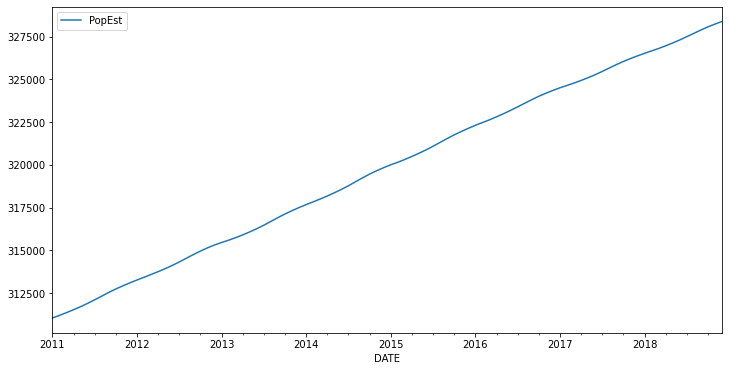

In [10]:
from statsmodels.tsa.ar_model import AR,ARResults

df = pd.read_csv('data\\Time Series\\uspopulation.csv',index_col='DATE',parse_dates=True)

df.index.freq='MS'

df.plot(figsize=(12,6))

We can see that the data has a linear trend so AR will work really well here.

We have 96 Months of data and we want to predict 12 months worth of data so we will need to train on 84 and use the 12 as a test.

In [11]:
train = df.iloc[0:84]
test = df.iloc[84:]

import warnings
warnings.filterwarnings('ignore')

we can fit an AR order one model:

In [12]:
model = AR(train['PopEst'])
ar_1_fit = model.fit(maxlag=1)

ar_1_fit.params

start = len(train)
end = len(train) + len(test)-1

Let's check the fit of AR(1) model based on our test set:

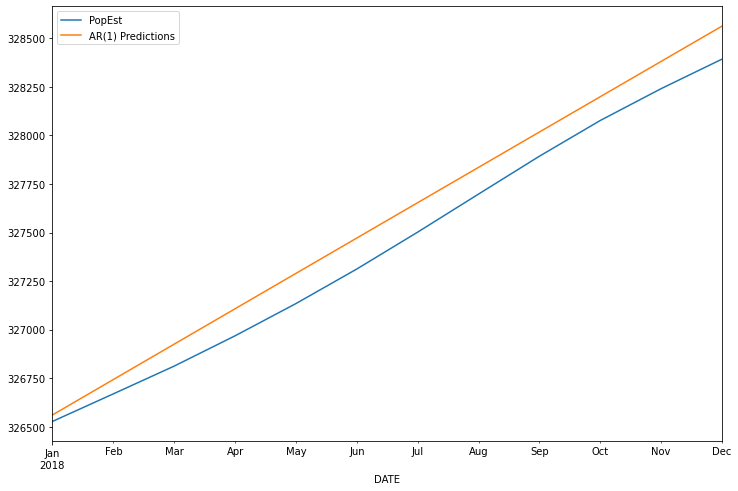

In [13]:
predictions_1 = ar_1_fit.predict(start,end)
predictions_1 = predictions_1.rename('AR(1) Predictions')
test.plot(figsize=(12,8),legend=True)
predictions_1.plot(legend=True)

We can see we have the general trend but we are not exact so let's check order 2:

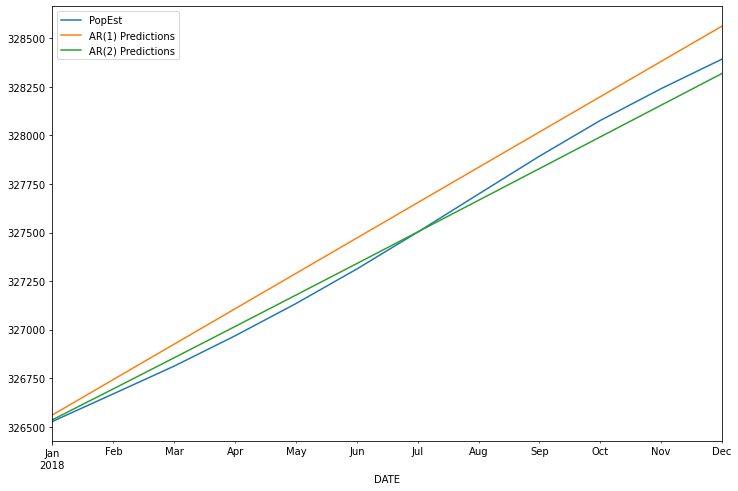

In [14]:
model2 = AR(train['PopEst'])
AR2Fit = model2.fit(maxlag=2)

predictions_2 = AR2Fit.predict(start,end)
predictions_2 = predictions_2.rename('AR(2) Predictions')
test.plot(figsize=(12,8),legend=True)
predictions_1.plot(legend=True)
predictions_2.plot(legend=True)

How can we decide on the best order value? We can get statsmodels to do the predictions:

Leave out the maxlag and Stats models will do the assesment itself. We can change IC to determine which is the best one.

AR1 MSE was : 17449.714221708866
AR2 MSE was : 2713.258645035927
AR8 MSE was : 186.9743309574485


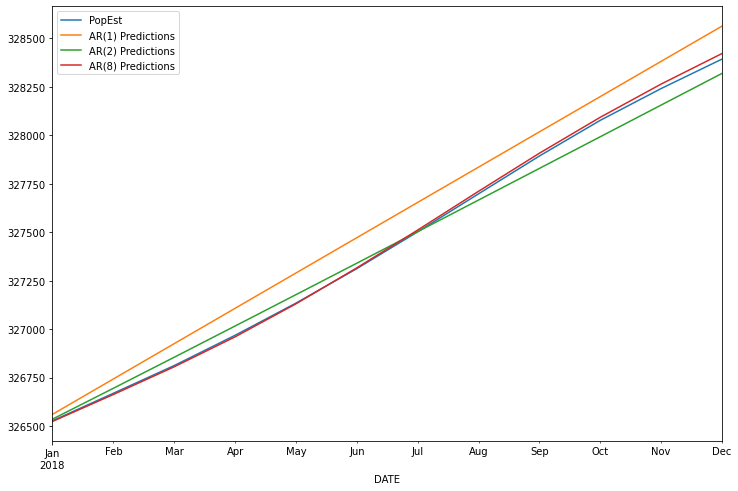

In [15]:
model3 = AR(train['PopEst'])
AR3Fit = model3.fit(ic='t-stat')
AR3Fit.params

from sklearn.metrics import mean_squared_error

labels = ['AR1','AR2','AR8']

predictions_3 = AR3Fit.predict(start,end)
predictions_3 = predictions_3.rename('AR(8) Predictions')

predictions = [predictions_1,predictions_2,predictions_3]

for i in range(3):
    error = mean_squared_error(test,predictions[i])
    print(f'{labels[i]} MSE was : {error}')

test.plot(figsize=(12,8),legend=True)
predictions_1.plot(legend=True)
predictions_2.plot(legend=True)
predictions_3.plot(legend=True)

Now that we are happy with the predictions we can now look at forecasting for the future!

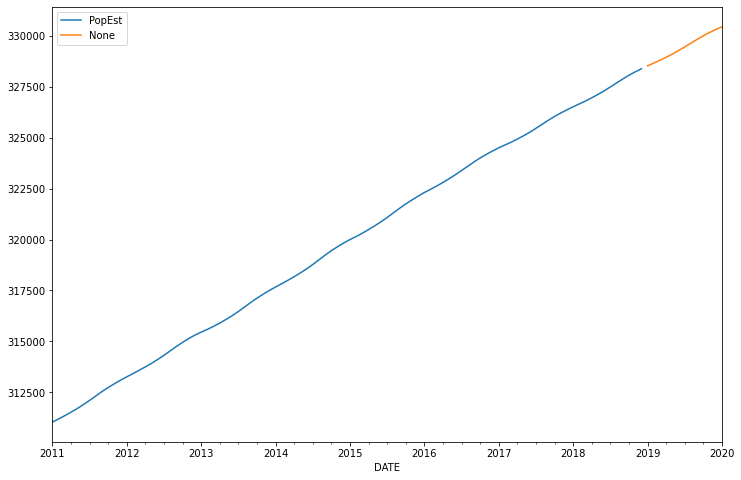

In [16]:
model = AR(df['PopEst'])
AR_fit = model.fit()

forecasted_values = AR_fit.predict(start=len(df),end=len(df)+12)

df['PopEst'].plot(figsize = (12,8),legend=True)
forecasted_values.plot(legend=True)

### Descriptive Statistics and tests:

We need to know something about the data in order to explore the underlying attributes.

We will need to look at stationarity, independence ect.

#### Stationarity:

We can use the augmented Dickey Fuller test. This will use a null hypothesis test and provide a p value to determine if it is stationary.

If p is less than 0.05 we reject so we assume the data is stationary.

#### Independence:

Granger Causality Test used to dermine if one time series is useful to predict another.

#### other descriptives

Is around evaluating the forecasts:

MAE
MSE
RMSE

still need to look at AIC and BIC

AIC - Akaike Information Criterion:

evaluates a collection of models and estimates the quality of each model relative to the others.

Penalties are provided to the number of parameters that are used. so simple models that do well can have a higher score than complex models due to the number of parameters.

BIC - Bayesian Information Criterion

Is very similar to AIC except the mathematics behind it.

We will also look at Seasonality plots to see if there is any seasonality present in the data.

We will now see how to do the descriptives:

In [17]:
df1 =pd.read_csv('Data\\Time Series\\airline_passengers.csv',index_col='Month',parse_dates=True)

df2 = pd.read_csv('Data\\Time Series\\DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)

Augmented Dickey Fuller test:

In [18]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df1['Thousands of Passengers'])
dfout = pd.Series(dftest[0:4],index=['ADF Statistic','p-Value','# Lags Used','# Observations'])

for key, val in dftest[4].items():
    dfout[f'Critical value ({key})']=val
dfout

ADF Statistic             0.815369
p-Value                   0.991880
# Lags Used              13.000000
# Observations          130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64

We can see the second value is our p-Value.

Based on this value we can see that is higher than 0.05 therefore we will not reject the null hypothesis and can conclude the data is not stationary.

Let's try with the second data set:

In [19]:
adfuller(df2['Births'])

(-4.808291253559762,
 5.243412990149882e-05,
 6,
 358,
 {'1%': -3.448748905151901,
  '5%': -2.8696473721448728,
  '10%': -2.5710891239349585},
 2343.8290926464197)

Looking at dependence, please note this data is generated and not from real world environment

From this we can see that the p-value is less that 0.05 therefore we can conclude the data is stationary

In [20]:
df3 = pd.read_csv('Data\\Time Series\\samples.csv',index_col=0,parse_dates=True)

Let's start by plotting these out:

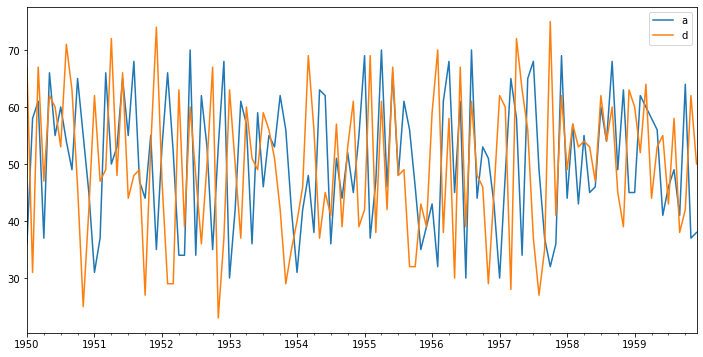

In [21]:
df3[['a','d']].plot(figsize=(12,6))

let's import Granger Causality test:

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


From this information we can see very low p-values from lag 2 onwards so we know that there is causality in the varaibles from lag 2.

### Visulizing Seasonality:


Let's see a way to plot out the seasonality effects:

ValueError: Expected frequency MS. Got Q

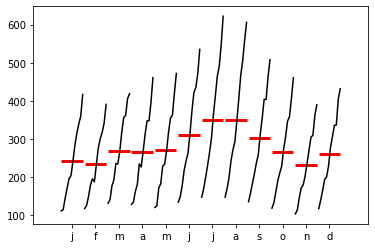

In [23]:
df = pd.read_csv('data\\Time Series\\airline_passengers.csv',index_col='Month',parse_dates=True)
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

month_plot(df['Thousands of Passengers']);
quarter_plot(df['Thousands of Passengers']);

